In [2]:
#Import Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
#pip install missingno
import missingno as msno
#pip install geopy
from geopy.geocoders import Nominatim


In [3]:
#Set Working Dir
path='C:/Users/tiward.FHMC.000/Desktop/Python Project'
os.chdir(path)
os.getcwd()

'C:\\Users\\tiward.FHMC.000\\Desktop\\Python Project'

In [5]:
# Create List of Source Files
Source_List=!cd Source Files & dir *.csv* /B # Must Run Outside Run File Command


In [6]:
#import Data
for file in Source_List:
        x='D'+file[0:4]
        print(x)
        path='Source Files/'+file
        print (path)
        exec("%s = pd.read_csv(path, dtype='str',low_memory=False)" % (x))
        if x =='D2003':
            Main=D2003                  
        else:
            exec("Main = Main.append(%s, ignore_index=True)"%(x))          


D2003
Source Files/2003_tsr_public_dataset.csv
D2004
Source Files/2004_tsr_public_dataset.csv
D2005
Source Files/2005_tsr_public_dataset.csv
D2006
Source Files/2006_tsr_public_dataset.csv
D2007
Source Files/2007_tsr_public_dataset.csv
D2008
Source Files/2008_tsr_public_dataset.csv
D2009
Source Files/2009_tsr_public_dataset.csv
D2010
Source Files/2010_tsr_public_dataset.csv
D2011
Source Files/2011_tsr_public_dataset.csv
D2012
Source Files/2012-tsr-public-dataset.csv


In [9]:
#Discuss Variable to Keep and Repetitive Varaiables
Main=Main[Main.salary.astype('float') >0] # Remove Salary Equal to or Less Than 0
Main['salary']=Main.salary.astype('float')
#Main.describe()
Main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1616995 entries, 0 to 1624886
Data columns (total 61 columns):
fy                     1616995 non-null object
rcdt                   1616995 non-null object
dst_name               1616957 non-null object
dst_addr               1616957 non-null object
dst_city               1616957 non-null object
dst_st                 1616957 non-null object
dst_zip                1616957 non-null object
dst_zip_plus4          1616957 non-null object
sch_num                1616995 non-null object
sch_name               1616977 non-null object
sch_addr               1499487 non-null object
sch_city               1499487 non-null object
sch_st                 1499487 non-null object
sch_zip                1499487 non-null object
sch_zip_plus4          1499487 non-null object
last_name              1616995 non-null object
first_name             1616995 non-null object
mid_init               1616995 non-null object
gender                 1616995 non-null o

In [ ]:
#Visualize Missing Data
msno.heatmap(Main)
msno.bar(Main,labels=True)



In [16]:
#Setup Boxplot Function   
def boxplot_sorted(df, by, column,plot_type):
  df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
  meds = df2.median().sort_values()
  if plot_type == 'P':
      df3=df2[meds.index]
      df3.boxplot(figsize=(10,20),vert=False)
  else :
      df3=df2[meds.index]
      plt.xticks(rotation=45)
      sns.catplot(kind="box", data=df3, height=8.27,aspect=2,orient ='h')
      #sns.swarmplot(data=df3, size=2, color=".3", linewidth=0)




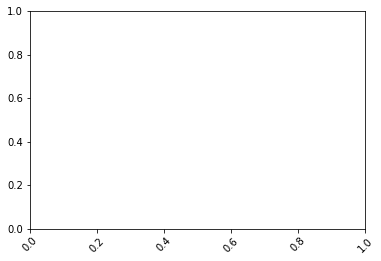

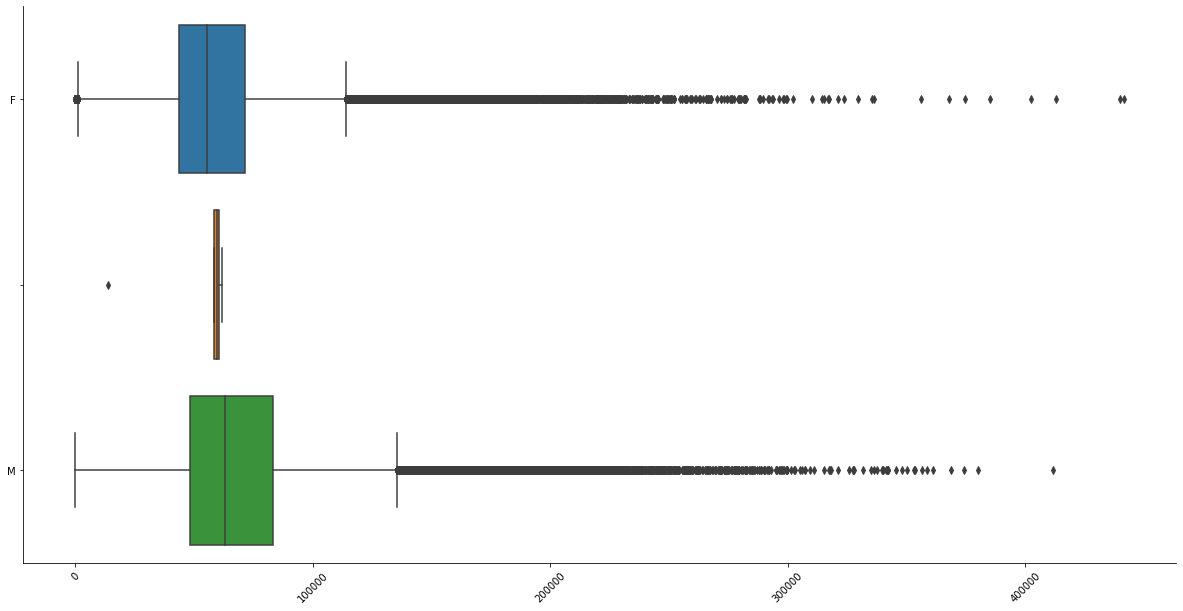

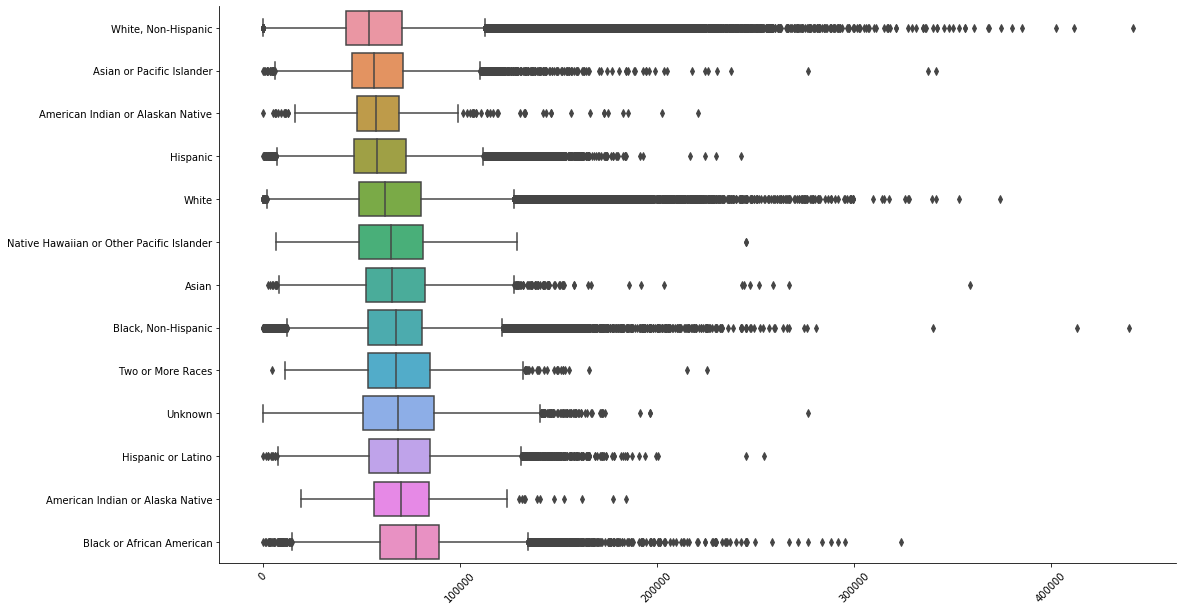

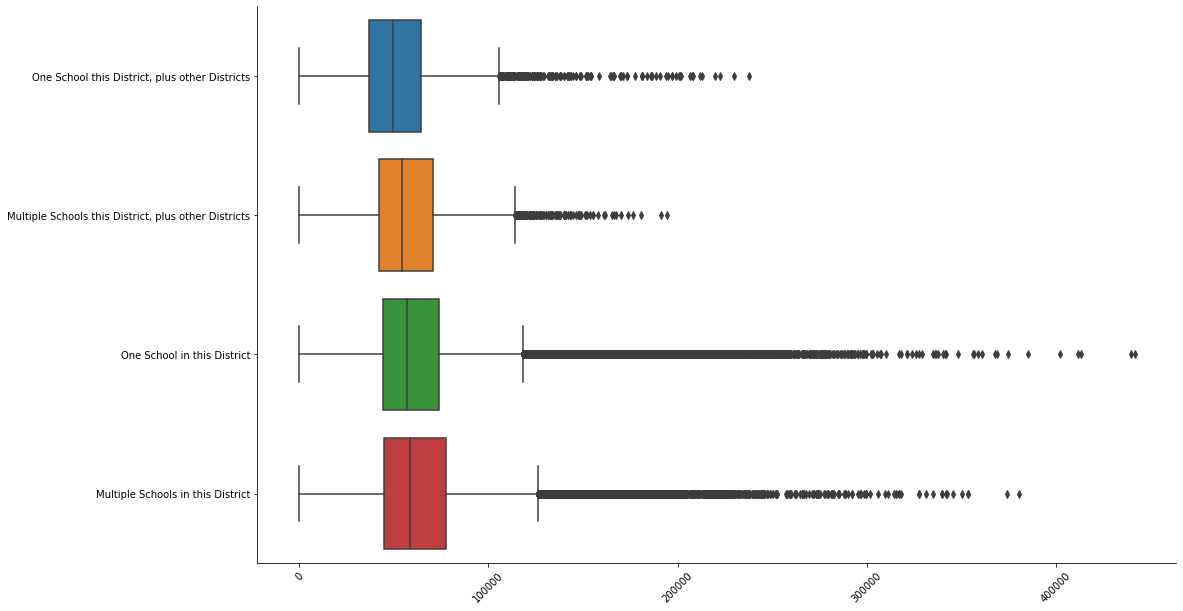

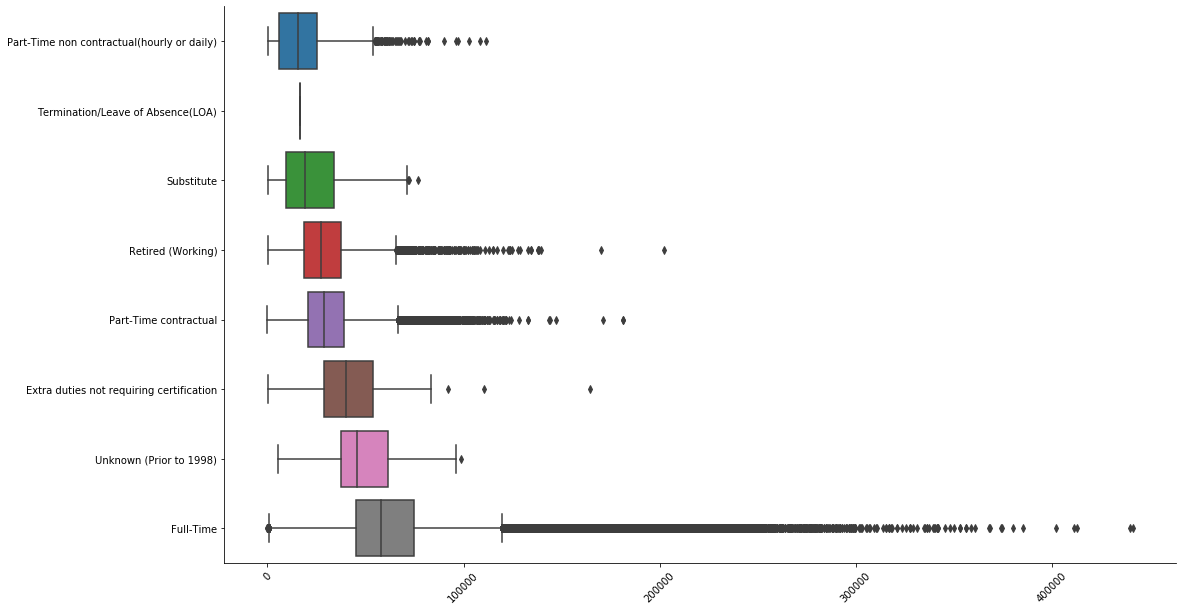

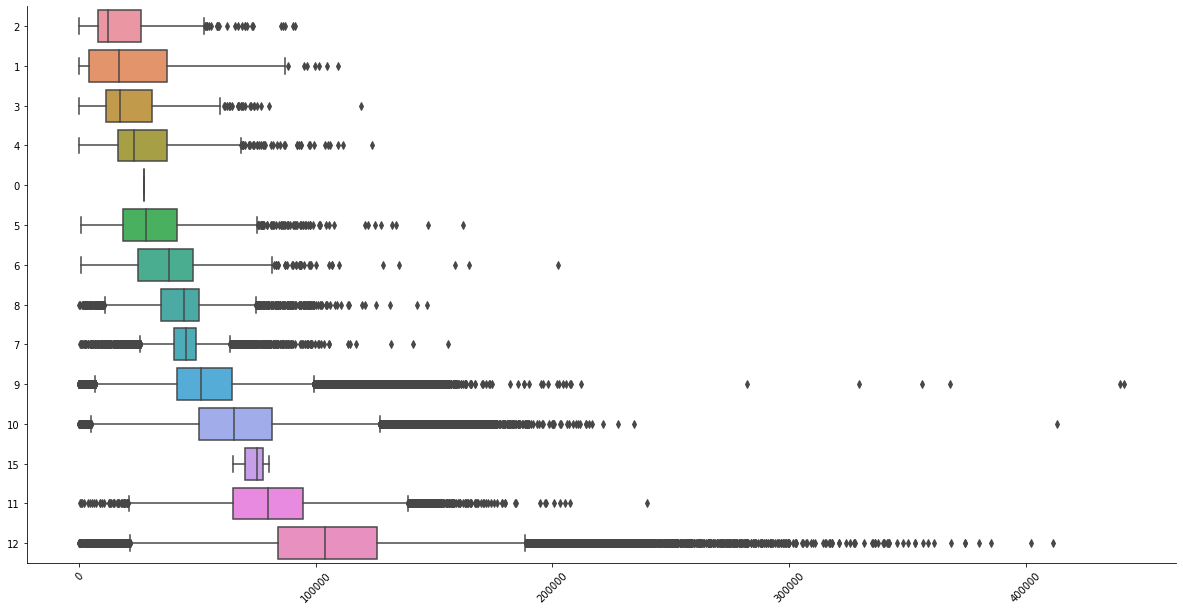

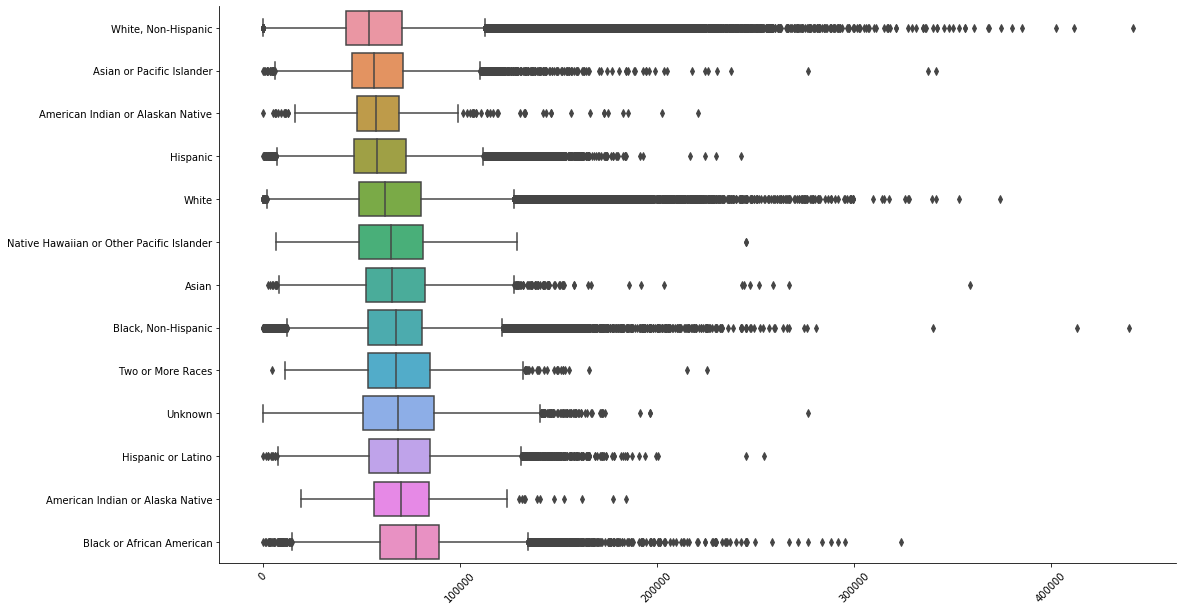

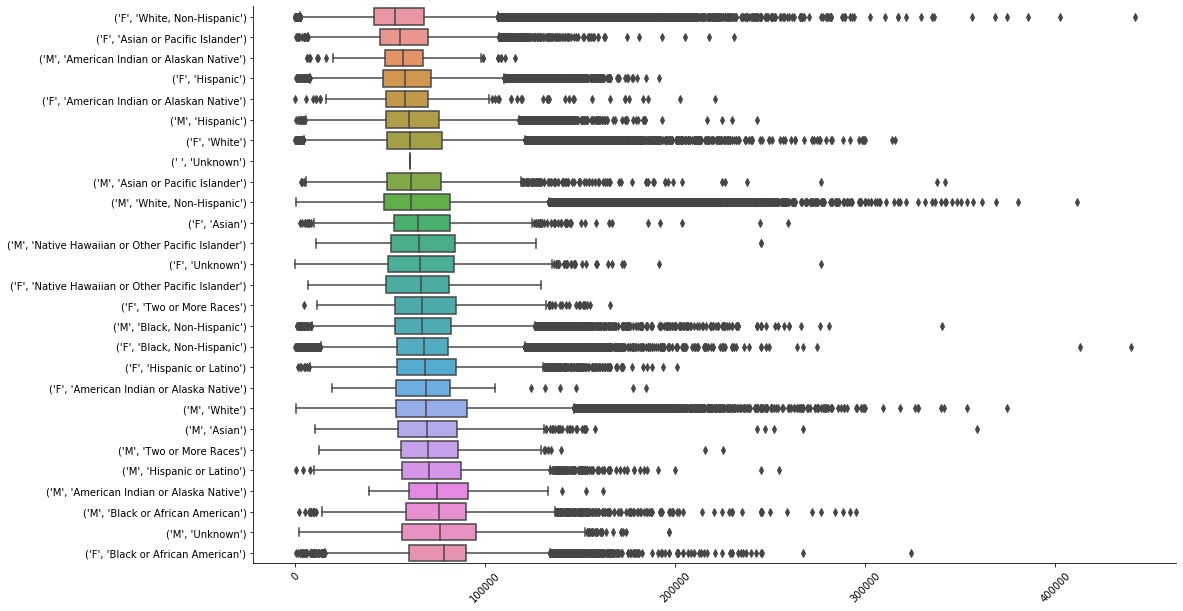

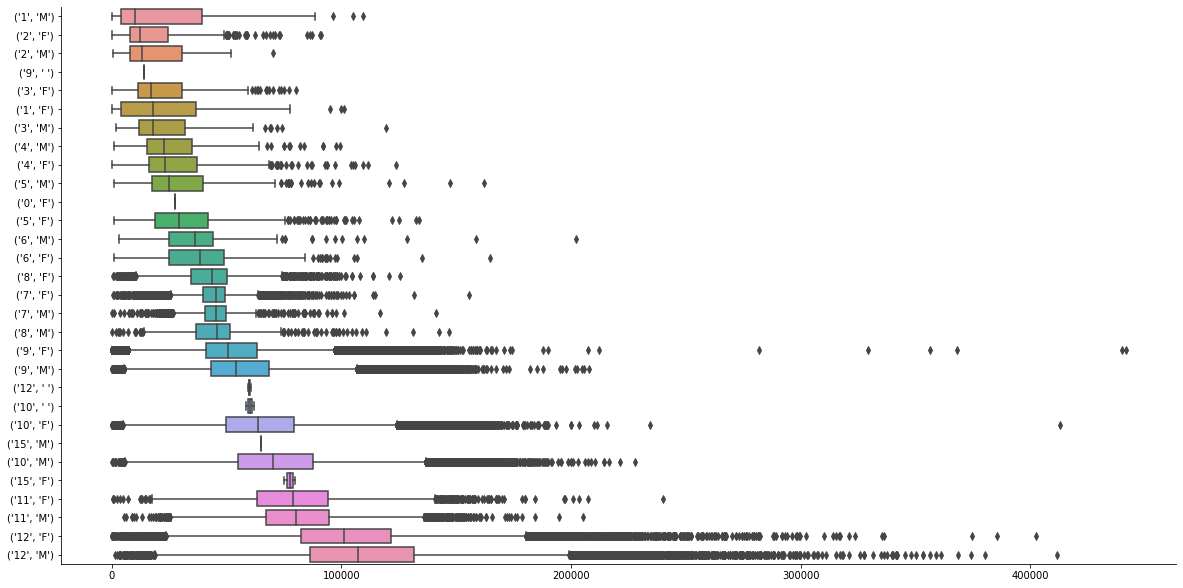

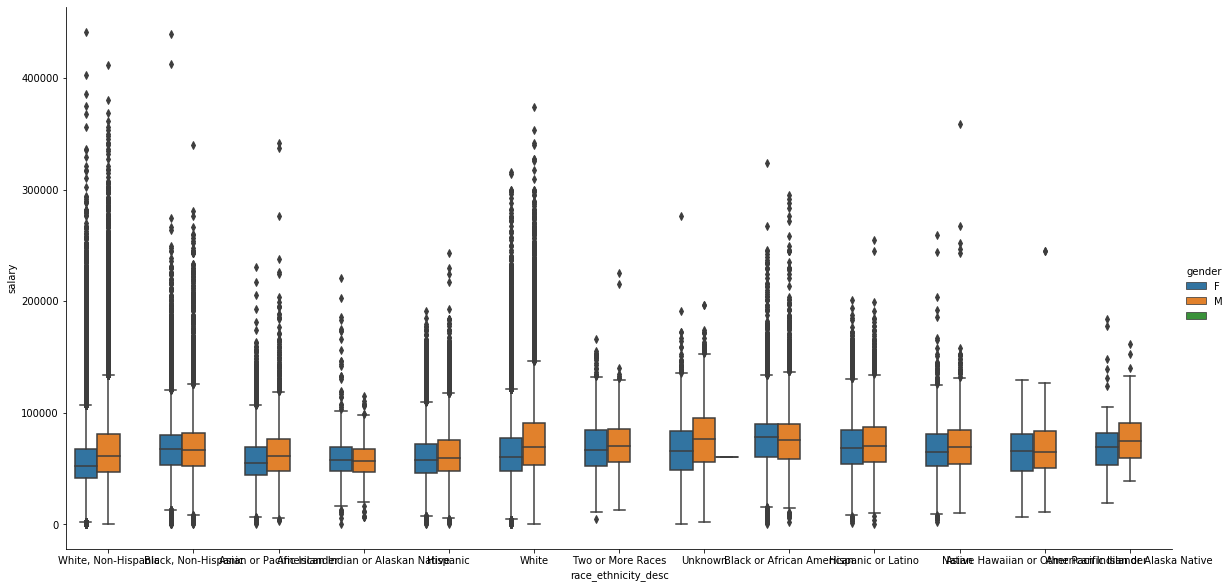

In [17]:
#Various Box Plots of Different Dimesion of Data
#Main.boxplot(column=['salary'],by=['gender'],figsize=(15,5),vert =False) #BoxPlot of Salary vs. Gender
#Main.boxplot(column=['salary'],by=['race_ethnicity_desc'],figsize=(20,15),rot=0,vert=False) #BoxPlot of Salary vs. Ethnicity
#Main.boxplot(column=['salary'],by=['location_desc'],figsize=(20,20),rot=0,vert =False) #BoxPlot of Salary vs. School Location
#Main.boxplot(column=['salary'],by=['emply_desc'],figsize=(20,20),rot=45) #BoxPlot of Salary vs. Gender
#Main.boxplot(column=['salary'],by=['months_employed'],figsize=(20,20),rot=45) #BoxPlot of Salary vs. Gender
#Main.boxplot(column=['salary'],by=['pos_desc'],figsize=(20,20),rot=0,vert=False) #BoxPlot of Salary vs. Gender
boxplot_sorted(Main,'gender','salary','s')
boxplot_sorted(Main,'race_ethnicity_desc','salary','s')
boxplot_sorted(Main,'location_desc','salary','s')
boxplot_sorted(Main,'emply_desc','salary','s')
boxplot_sorted(Main,'months_employed','salary','s')
boxplot_sorted(Main,['gender','race_ethnicity_desc'],'salary','s')
boxplot_sorted(Main,['months_employed','gender'],'salary','s')
sns.catplot(x="race_ethnicity_desc", y="salary", hue='gender',kind="box", data=Main,height=8.27,aspect=2,orient='h')


City of Chicago SD 299               20007
Other Location                       12826
Lincoln Elem School                   9596
Washington Elem School                6318
Jefferson Elem School                 4186
Central Elem School                   3705
Lincoln Middle School                 3263
Adlai E Stevenson High School         3260
Neuqua Valley High School             2927
Evanston Twp High School              2869
Lyons Twp High Sch                    2841
New Trier Township H S Winnetka       2829
Warren Township High School           2647
Waukegan High School                  2617
Waubonsie Valley High School          2585
Rockford SD 205                       2560
Lane Technical High School            2530
Sangamon Area Spec Ed Dist            2520
Carl Sandburg High School             2462
Comm H S Dist 99 - South High Sch     2387
Central High School                   2359
Lincoln Elementary School             2346
Macon-Piatt Spec Educ Jnt Agr         2320
Oak Park & 

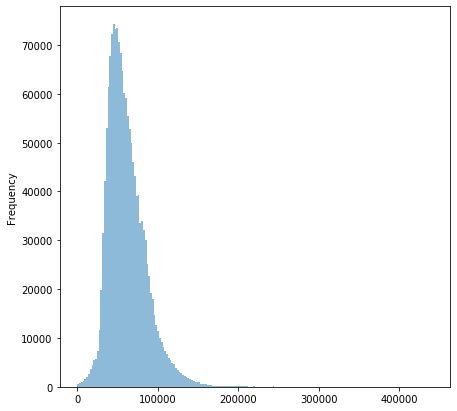

In [28]:
#Histogram of of Salary
Main['salary'].plot.hist(alpha=0.5, bins=200 ,figsize =(7,7))
#Plot of Counts
Main['sch_name'].value_counts() 
#.plot(kind='bar',figsize=(7,10))